In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import module as mod

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house1_power_blk2 = mod.load_dataset('data/house1_power_blk2_labels.zip')
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [3]:
house2_power_blk1 = mod.load_dataset('data/house2_power_blk1_labels.zip')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [4]:
windows = ['1h', '5min']

features_col = ['mains', 'hour']
for window in windows:
    house1_power_blk2, cols = mod.generate_features(house1_power_blk2, window=window)
    house2_power_blk1, cols = mod.generate_features(house2_power_blk1, window=window)
    features_col += cols

# 2. Algorithmes généraux : house 1 vs house 2

In [7]:
scaler = StandardScaler()
sample_idx = mod.pick_random_indexes(house2_power_blk1, 0.3)
X_train = scaler.fit_transform(house1_power_blk2[features_col].values)
X_test = scaler.transform(house2_power_blk1.loc[sample_idx, features_col].values)

y_train = house1_power_blk2['activity'].values
y_test = house2_power_blk1.loc[sample_idx, 'activity'].values

Score f_beta : 65.801%
Score accuracy : 66.630%


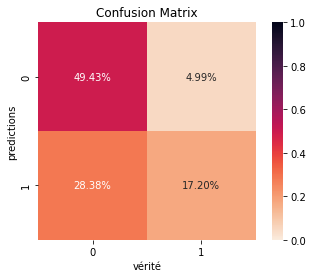

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=90, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 63.009%
Score accuracy : 64.925%


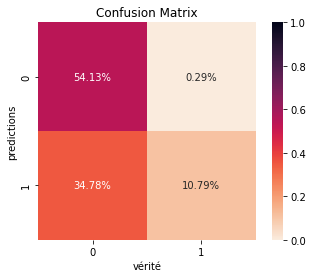

In [9]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 64.408%
Score accuracy : 65.704%


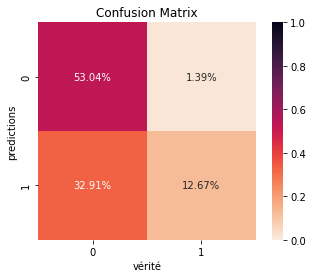

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train.ravel())
y_pred = hgbc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

# 3. Algorithmes généraux : house 2 vs house 1

In [17]:
scaler = MinMaxScaler()
sample_idx = mod.pick_random_indexes(house1_power_blk2, 0.3)
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
# Attention : ici on re-fit le scaler sur les données de la maison 2 (test)
X_test = scaler.fit_transform(house1_power_blk2.loc[sample_idx, features_col].values)

y_train = house2_power_blk1['activity'].values
y_test = house1_power_blk2.loc[sample_idx, 'activity'].values

Score f_beta : 71.436%
Score accuracy : 69.588%


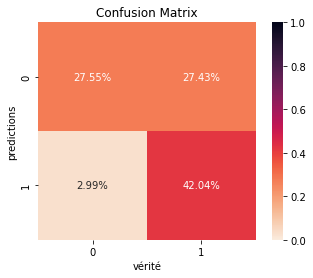

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=90, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 71.948%
Score accuracy : 69.912%


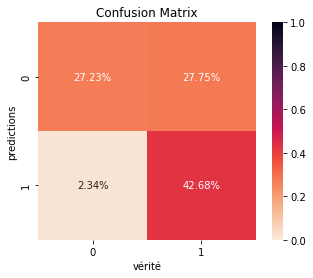

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 71.658%
Score accuracy : 69.365%


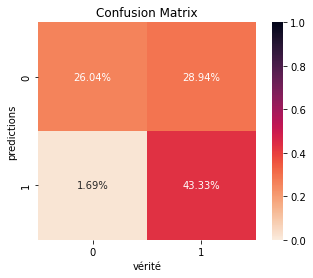

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train.ravel())
y_pred = hgbc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);